In [2]:
import numpy as np
import time
import multiprocessing as mp
import matplotlib as mpl
import matplotlib.pylab as pylab
from matplotlib import pyplot as plt
from scipy.special import lambertw
from sklearn.neighbors import NearestNeighbors

import sys
from os import path
current_folder = path.dirname(path.abspath('')); sys.path.append(current_folder)
from estimators import *

params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
def probability_inseparable_sphere(alpha,n):
    ''' 
    %probability_inseparable_sphere calculate theoretical probability for point
    %to be inseparable for dimension n
    %
    %Inputs:
    %   alpha is 1-by-d vector of possible alphas. Must be row vector or scalar
    %   n is c-by-1 vector of dimnesions. Must be column vector or scalar.
    %
    %Outputs:
    %   p is c-by-d matrix of probabilities.'''
    p = np.power((1-np.power(alpha,2)),(n-1)/2)/(alpha*np.sqrt(2*np.pi*n))
    return p

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def asPointwise(data,function, params, n_neighbors=100,n_cores=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    neigh = NearestNeighbors(n_neighbors)
    neigh.fit(data)
    knn   = neigh.kneighbors(return_distance=False)
    if n_cores > 1:
        pool = mp.Pool(n_cores)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]

## Usual separability plot

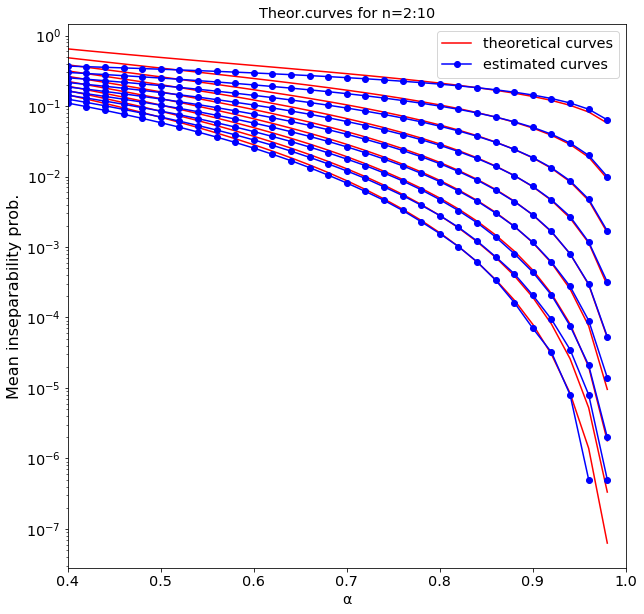

In [4]:
alphas = np.arange(.4,1,.02)[None]
ndims = np.arange(2,11)
plt.figure(figsize=(10,10))

for ndim in ndims:
    np.random.seed(0)
    data = randsphere(n_points=2000,ndim=ndim,radius=1)[0]
    n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0,alphas=alphas)
    
    n_min = min(ndims)
    n_max = max(ndims)
    if n_min<1:
        n_min = 1

    ns = np.arange(n_min,n_max+1)
    
    py_mean = np.mean(p_alpha,axis=1)    
    #plt.xticks(locs,labels);
    pteor = np.zeros((len(ns),len(alphas[0,:])))
    for k in range(len(ns)):
        for j in range(len(alphas[0,:])):
            pteor[k,j] = probability_inseparable_sphere(alphas[0,j],ns[k])
            
    if ndim == ndims[0]:
        for i in range(len(pteor[:,0])):
            if ndim == ndims[0] and i==0:
                plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r',label='theoretical curves')
            else:
                plt.semilogy(alphas[0,:],pteor[i,:],'-',color='r')
        plt.xlim(min(alphas[0,:]),1)
    
    if ndim == ndims[0]:
        if True in np.isnan(n_alpha):
                plt.semilogy(alphas[0,:np.where(np.isnan(n_alpha))[0][0]],py_mean[:np.where(np.isnan(n_alpha))[0][0]],'bo-')#label='estimated curves')
        else: 
            plt.semilogy(alphas[0,:],py_mean,'bo-',label='estimated curves')

        plt.xlabel('\u03B1'); plt.ylabel('Mean inseparability prob.',fontsize=16);
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))
        
    else:
        if True in np.isnan(n_alpha):
                plt.semilogy(alphas[0,:np.where(np.isnan(n_alpha))[0][0]],py_mean[:np.where(np.isnan(n_alpha))[0][0]],'bo-')
        else: 
            plt.semilogy(alphas[0,:],py_mean,'bo-');

        plt.xlabel('\u03B1'); plt.ylabel('Mean inseparability prob.',fontsize=16);
        plt.title('Theor.curves for n=%i:%i'%(n_min,n_max))

plt.legend()
plt.show()

#plt.figure()
#for ndim in ndims:
#    np.random.seed(0)
#    data = randsphere(n_points=1000,ndim=ndim,radius=1)[0]
#    n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0)
#    alpha_index = (n_alpha==n_single).tolist().index(True)
#    palpha_selected = p_alpha[alpha_index,:]
#    plt.hist(p_alpha[alpha_index,:][0],bins=20,alpha=.5)
#    plt.xlabel('inseparability prob.p for \u03B1=%2.2f'%(alphas[0,alpha_index]),fontsize=16); plt.ylabel('Number of values')
plt.show()

## Possibility to limit global maxdim to embedding dimension

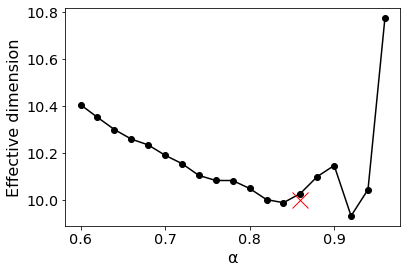

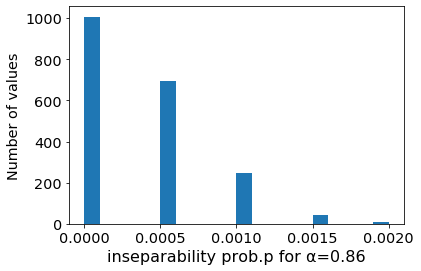

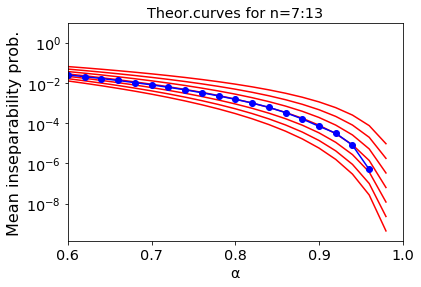

In [5]:
n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=1,limit_maxdim=True)

## Computing global pointwise ID + options

In [6]:
data = randsphere(n_points=20,ndim=3,radius=1)[0]

In [7]:
n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,
                                                                             ProducePlots=0,
                                                                             ncomp=1,
                                                                             ConditionalNumber=np.inf,
                                                                             alphas=np.arange(.2,1,.02)[None])

alpha_index = (n_alpha==n_single).tolist().index(True)
palpha_selected = p_alpha[alpha_index,:]
palpha_selected

3 components are retained using factor inf


array([0.1 , 0.  , 0.1 , 0.  , 0.1 , 0.1 , 0.05, 0.  , 0.05, 0.15, 0.05,
       0.  , 0.  , 0.15, 0.05, 0.  , 0.1 , 0.15, 0.1 , 0.15])

In [8]:
                                                                                  #other options:
                                                                                  #idx='all_inseparable'  
                                                                                  #idx= 5                  #force fully separable points to take value dim_separability(1/N)
n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',         force_definite_dim=False)
print(n_pointwise,'\n')
n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',         force_definite_dim=True)
print(n_pointwise)

14/20 points have nonzero inseparability probability for chosen alpha = 0.88, force_definite_dim = False
[2.43305769        nan 2.43305769        nan 2.43305769 2.43305769
 3.183533          nan 3.183533   2.01504222 3.183533          nan
        nan 2.01504222 3.183533          nan 2.43305769 2.01504222
 2.43305769 2.01504222] 

20/20 points have nonzero inseparability probability for chosen alpha = 0.88, force_definite_dim = True
[2.43305769 3.183533   2.43305769 3.183533   2.43305769 2.43305769
 3.183533   3.183533   3.183533   2.01504222 3.183533   3.183533
 3.183533   2.01504222 3.183533   3.183533   2.43305769 2.01504222
 2.43305769 2.01504222]


## What is the maximum dimension we can detect for a given cardinality and alpha ?

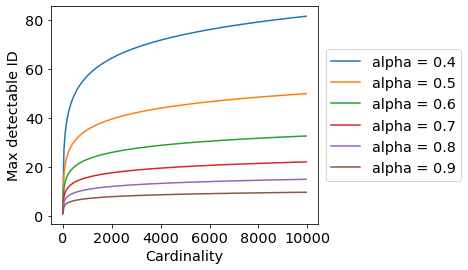

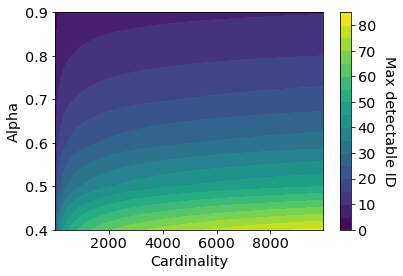

In [9]:
N=np.arange(2,10000,50)
alpha=np.arange(.4,1,.1)

alpha, N = np.meshgrid(alpha,N)

p  = 1/(N)
a2 = alpha**2
w = np.log(1-a2)
n = np.real(lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w))

#### Plotting
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

#### Zooming in on small cardinalities

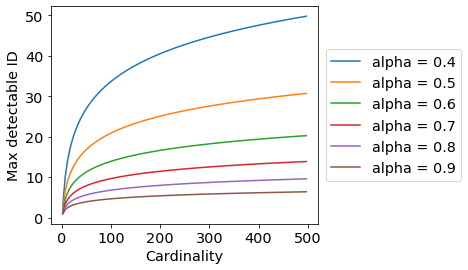

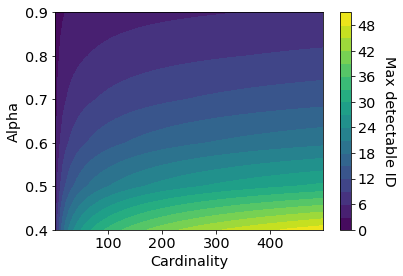

In [10]:
N=np.arange(2,500,5)
alpha=np.arange(.4,1,.1)

alpha, N = np.meshgrid(alpha,N)

p  = 1/(N)
a2 = alpha**2
w = np.log(1-a2)
n = np.real(lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w))

#### Plotting
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

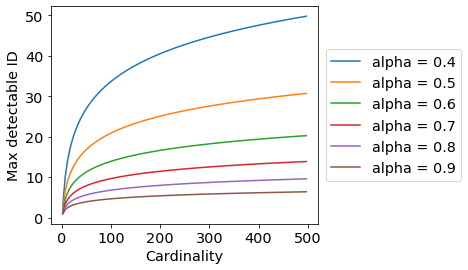

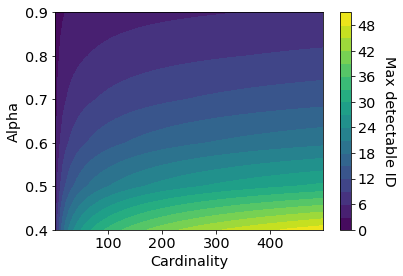

In [11]:
f = plt.figure()
ax = plt.subplot(111)
plt.xlabel('Cardinality')
plt.ylabel(f'Max detectable ID')#, alpha = {alpha}')
ax.plot(N,n)
#plt.yscale('log')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend([f'alpha = {round(a,2)}' for a in alpha[0]],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.xlabel('Cardinality')
plt.ylabel('Alpha')
cs = plt.contourf(N,alpha,n,16)
cb = plt.colorbar(); cb.ax.get_yaxis().labelpad = 20; cb.set_label('Max detectable ID', rotation=270)

## 

## Computing kNN intrinsic dimension
From ESS paper:

"The procedure for finding a local data set is to choose a
point p from the whole data set and using its nearest
neighbors as the local data set. **The point p is not put into the local data set** since we want to assume that the local data is drawn from
a uniform distribution on a hyperball, and p will be in the center of
the hyperball, not drawn randomly."

### Testing robustness of local estimators to very high intrinsic dimension

In [12]:
data = randsphere(n_points=200,ndim=300,radius=1)[0] # mimic a local dataset

In [13]:
runANOVAglobal(data,k=200) # ANOVA underestimates a lot

array([[5]], dtype=uint8)

In [14]:
runDANCo(data) # FastDANCo can produce crazy numerical errors

array([1.9014759e+31])

In [15]:
danco_py(data,k=10,D=600,fractal=False)['de'] # regular DANCo overestimates

Computing DANCo calibration data for N = 200, k = 10 for dimensions 1 to 600


598

In [16]:
ess_py(data)[0] # ESS is very stable

292.37847625332654

In [17]:
twonn_py(data) # TwoNN underestimates

87.32074352815361

In [18]:
corint_py(data) # correlation dimension underestimates

array([59.71876151])

In [19]:
mada_py(data) # mada underestimates

68.88443791110913

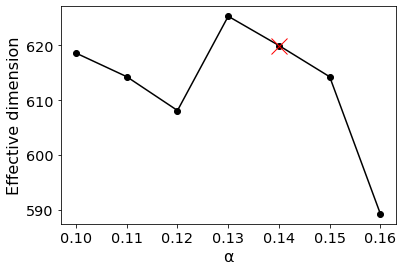

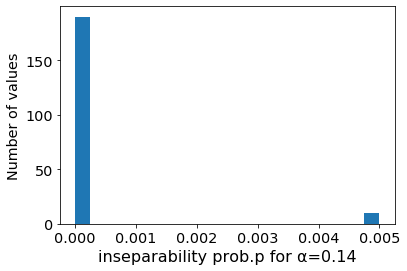

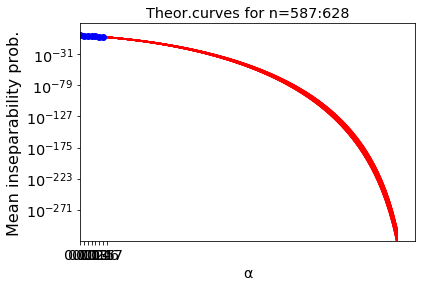

(array([618.60817203, 614.29868576, 608.12945377, 625.33509699,
        619.99318616, 614.2876988 , 589.253563  ,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,     

In [20]:
SeparabilityAnalysis(data,alphas=np.arange(.1,1,.01)[None]) # separability overestimates 

### Local ID vs inseparability - basic example

In [26]:
shuffle = np.random.choice(10,size=10,replace=False)
shuffled_dims = shuffle+2
print("shuffled balls' dimensions: ",shuffled_dims)

random_seed = 0
ndatasets = 10
npoints = 500 #per ball
n_cores = 4 #set higher to run the pointwise estimation in parallel
n_neighbors = 100 #neighborhood size for ID estimation in K-neighborhoods


datasets = []
for center_idx,i in enumerate(shuffle):
    np.random.seed(random_seed)
    datasets.append(randsphere(n_points=npoints,ndim=i+2,radius=.5,center = [center_idx,0]+[0]*i)[0])
    
emb_dimension = 11 #for each estimation, the embedding dimension is set as the dimension of the highest-dimensional ball we generated (11)

shuffled balls' dimensions:  [ 7  4  2  3 10  8  6  9  5 11]


estimated global dimension:  7.09 4.02 1.98 2.99 10.27 8.32 6.09 8.92 5.02 11.79 



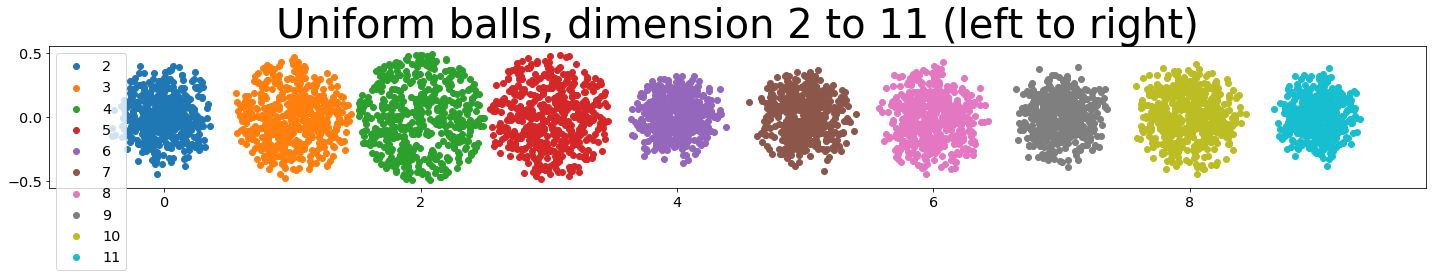

In [27]:
fig,ax = plt.subplots(figsize=(20,5))

#estimate dimension
datasets_inseparability = []
for i in range(ndatasets):
    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(datasets[i],ProducePlots=0,ConditionalNumber=np.inf)
    palpha_selected = p_alpha[(n_alpha==n_single).tolist().index(True),:]

    datasets_inseparability.append(palpha_selected)
    
    print('estimated global dimension: ',end=' ') if i==0 else None
    print(round(n_single[0],2),end=' ')
print('\n')

#plot
plt.title('Uniform balls, dimension 2 to 11 (left to right)',fontsize=40)
for i in range(ndatasets):
    ax.scatter(datasets[i][:,0],datasets[i][:,1],label=str(i+2))
    ax.axis('scaled')

ax.legend()
plt.tight_layout()
plt.show()

In [28]:
list_allballs = []
list_inseparability = []
list_inseparability_id = []
list_fisher_pw = []

print('t = time in seconds')
print(f'using n_cores={n_cores}\n')
for i in range(ndatasets):
    
    allballs = np.zeros((npoints*(i+1),emb_dimension)) #initialize data array
    
    #loop merging datasets 0 to i into one array (balls are placed along overlapping dimensions)
    for i0,_dataset in enumerate(datasets[:i+1]):
        allballs[i0*npoints:(i0+1)*npoints,:_dataset.shape[1]] = _dataset
    list_allballs.append(allballs)
    
    #estimate global intrinsic dimension, inseparability
    start=time.time()
    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(allballs,ProducePlots=0,ConditionalNumber=np.inf)
    palpha_selected = p_alpha[(n_alpha==n_single).tolist().index(True),:]
    print('estimated global dimension:',end=' ')
    print(f'{round(n_single[0],2):.2f}',f't: {round(time.time()-start,2):.2f}',end='    ')
    
    #estimate pointwise intrinsic dimension from inseparability
    n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected', force_definite_dim=True,verbose=False)
    print('mean of inseparability ID estimates:',end=' ')
    print(f'{round(np.nanmean(n_pointwise),2):.2f}',f't: {round(time.time()-start,2):.2f}',end='    ')
    
    #estimate local intrinsic dimension
    start=time.time()
    fisher_pw = asPointwise(data=allballs,
                            function=SeparabilityAnalysis,
                            params=dict(ProducePlots=0,ConditionalNumber=np.inf),
                            n_neighbors=n_neighbors,
                            n_cores=n_cores)
    fisher_pw = np.array([est[1][0] for est in fisher_pw])
    print('mean of local estimates:',end=' ')
    print(round(np.mean(fisher_pw),2),f't: {round(time.time()-start,2):.2f}')
    
    #store results
    list_inseparability.append(palpha_selected)
    list_inseparability_id.append(n_pointwise)
    list_fisher_pw.append(fisher_pw)

t = time in seconds
using n_cores=4

estimated global dimension: 7.09 t: 0.02    mean of inseparability ID estimates: 6.76 t: 0.03    mean of local estimates: 7.43 t: 0.52
estimated global dimension: 4.62 t: 0.14    mean of inseparability ID estimates: 5.36 t: 0.15    mean of local estimates: 5.71 t: 0.90
estimated global dimension: 3.24 t: 0.35    mean of inseparability ID estimates: 4.50 t: 0.38    mean of local estimates: 4.44 t: 1.28
estimated global dimension: 3.27 t: 0.40    mean of inseparability ID estimates: 4.22 t: 0.42    mean of local estimates: 4.09 t: 1.47
estimated global dimension: 3.86 t: 0.59    mean of inseparability ID estimates: 5.43 t: 0.66    mean of local estimates: 5.36 t: 2.36
estimated global dimension: 4.22 t: 0.81    mean of inseparability ID estimates: 6.03 t: 0.85    mean of local estimates: 5.94 t: 2.21
estimated global dimension: 4.48 t: 0.87    mean of inseparability ID estimates: 6.18 t: 0.91    mean of local estimates: 5.98 t: 2.63
estimated global d

### Plot, coloring with inseparability

setting 0 values to 1e-100 for correct plotting with logscale


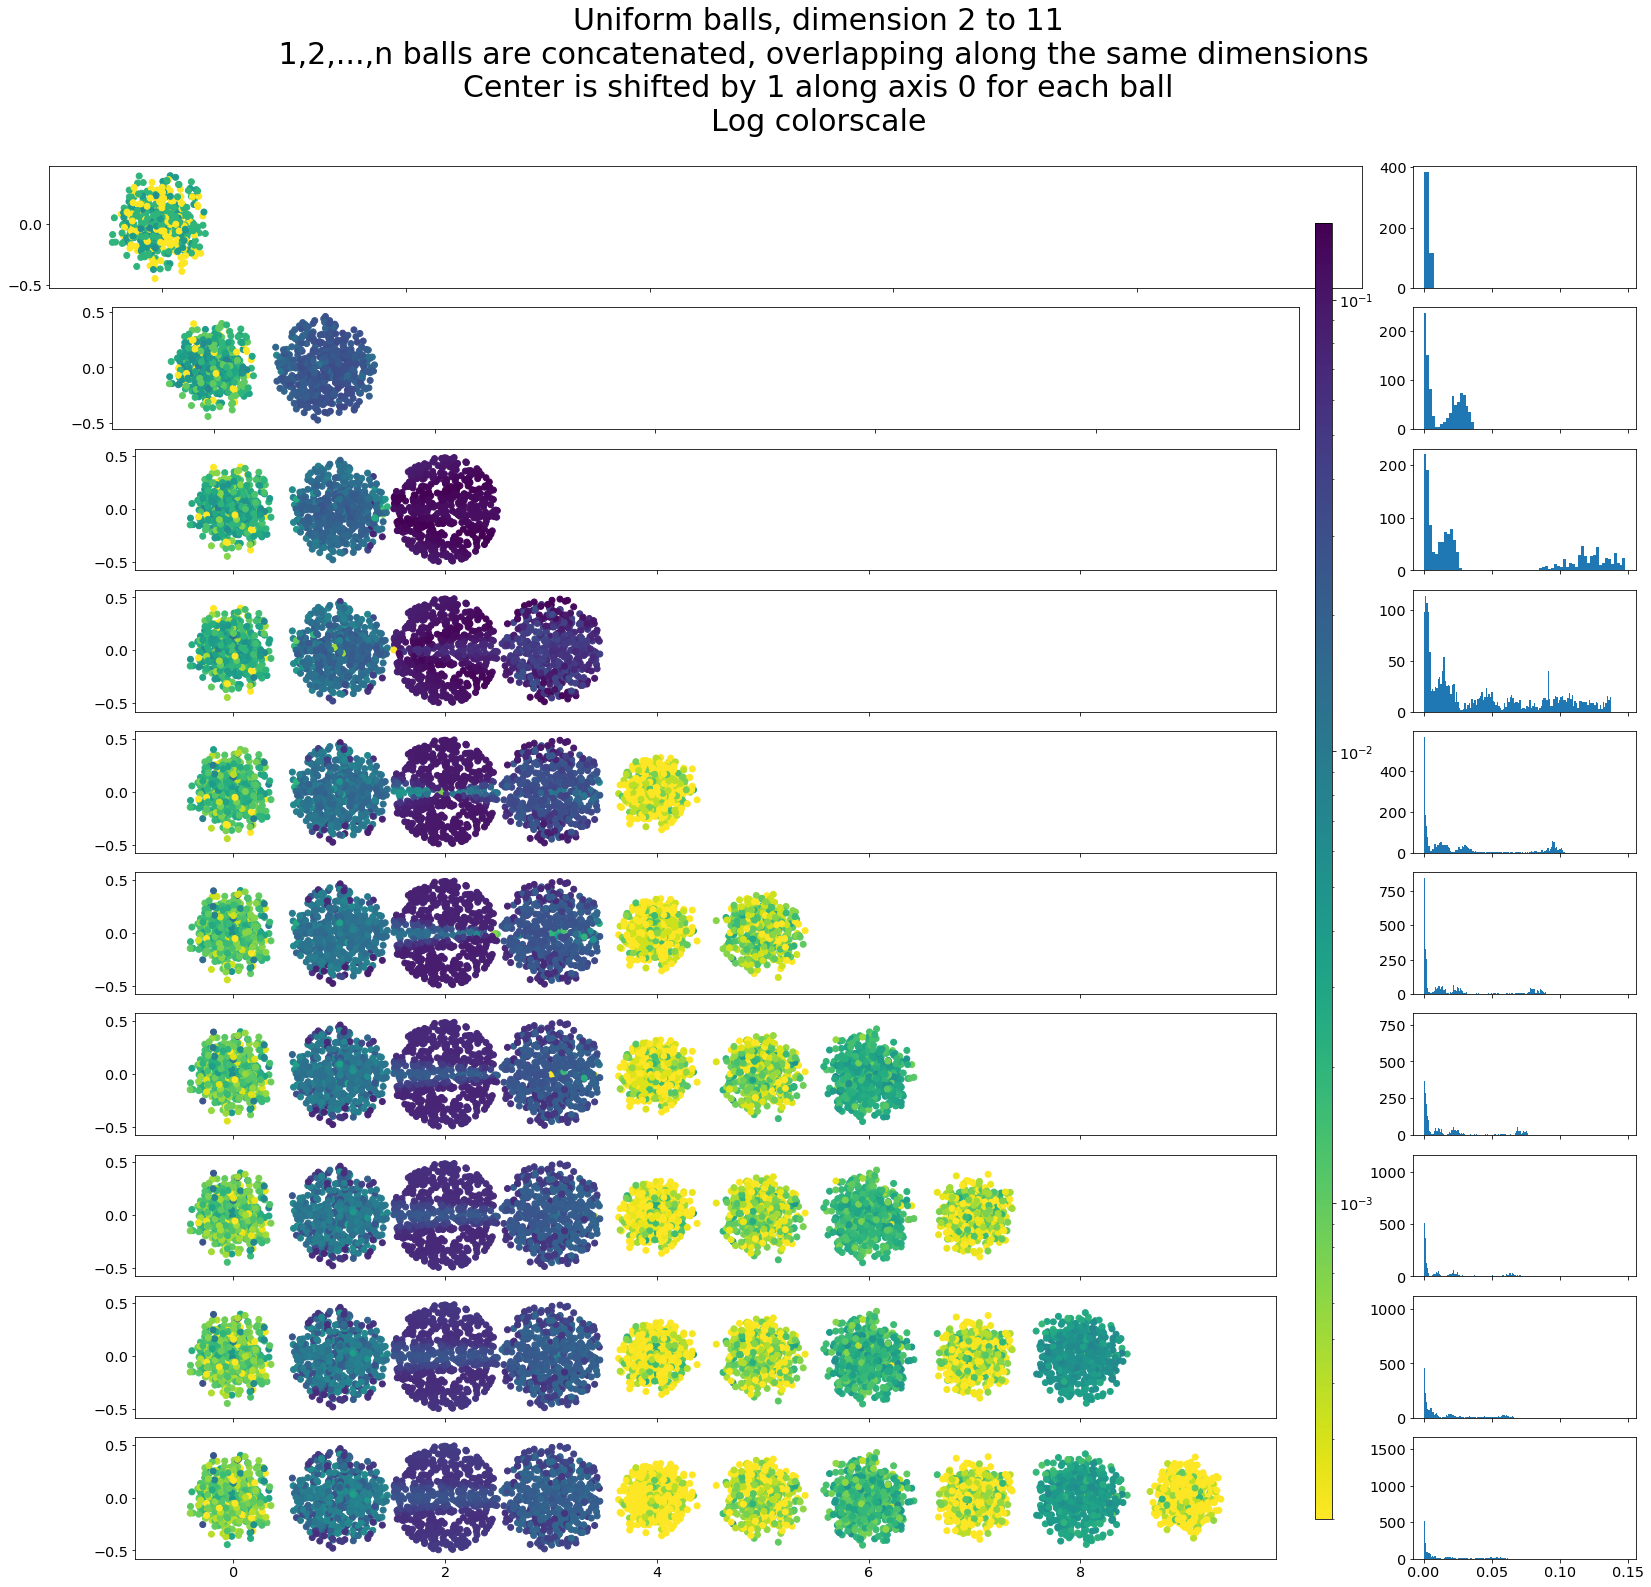

In [29]:
print('setting 0 values to 1e-100 for correct plotting with logscale')
for i in list_inseparability:
    i[i==0]=1e-100

fig,axes = plt.subplots(10,2,figsize=(23,20),gridspec_kw={'width_ratios': [6, 1]},sharex='col')#,sharey='col')
plt.suptitle('Uniform balls, dimension 2 to 11\n 1,2,...,n balls are concatenated, overlapping along the same dimensions\nCenter is shifted by 1 along axis 0 for each ball\nLog colorscale',fontsize=30,y=1.1)
ax = list(axes.flat)
xmin = sorted(np.unique(np.concatenate(list_inseparability)))[1]
xmax = np.max(np.concatenate(list_inseparability))

j=0
for i in range(ndatasets*2):
    if i%2==0:
        color_subplot = ax[i].scatter(list_allballs[j][:,0],list_allballs[j][:,1],label=str(j),c=list_inseparability[j],vmin=xmin,vmax=xmax,norm=mpl.colors.LogNorm(),cmap='viridis_r')
        ax[i].axis('scaled')
        j+=1
    else:
        ax[i].hist(list_inseparability[j-1],bins=int(len(np.unique(list_inseparability[j-1]))/2))


cmap = plt.cm.viridis_r #reverse viridis colorscale for consistency with pointwise ID (yellow = high ID, dark blue = low ID)
norm = mpl.colors.LogNorm(vmin=xmin,vmax=xmax)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cbaxes = fig.add_axes([.8, .05, .01, .9]) 
#formatter = LogFormatter(10, labelOnlyBase=False) 
cb=fig.colorbar(sm,ax=axes.ravel().tolist(),cax=cbaxes)
#cb.set_ticks(list(np.linspace(xmin,xmax,10)))
#cb.set_ticklabels(list(np.round(np.linspace(xmin,xmax,10),2)))
plt.tight_layout()
plt.show()

### Plot, coloring with ID from inseparability

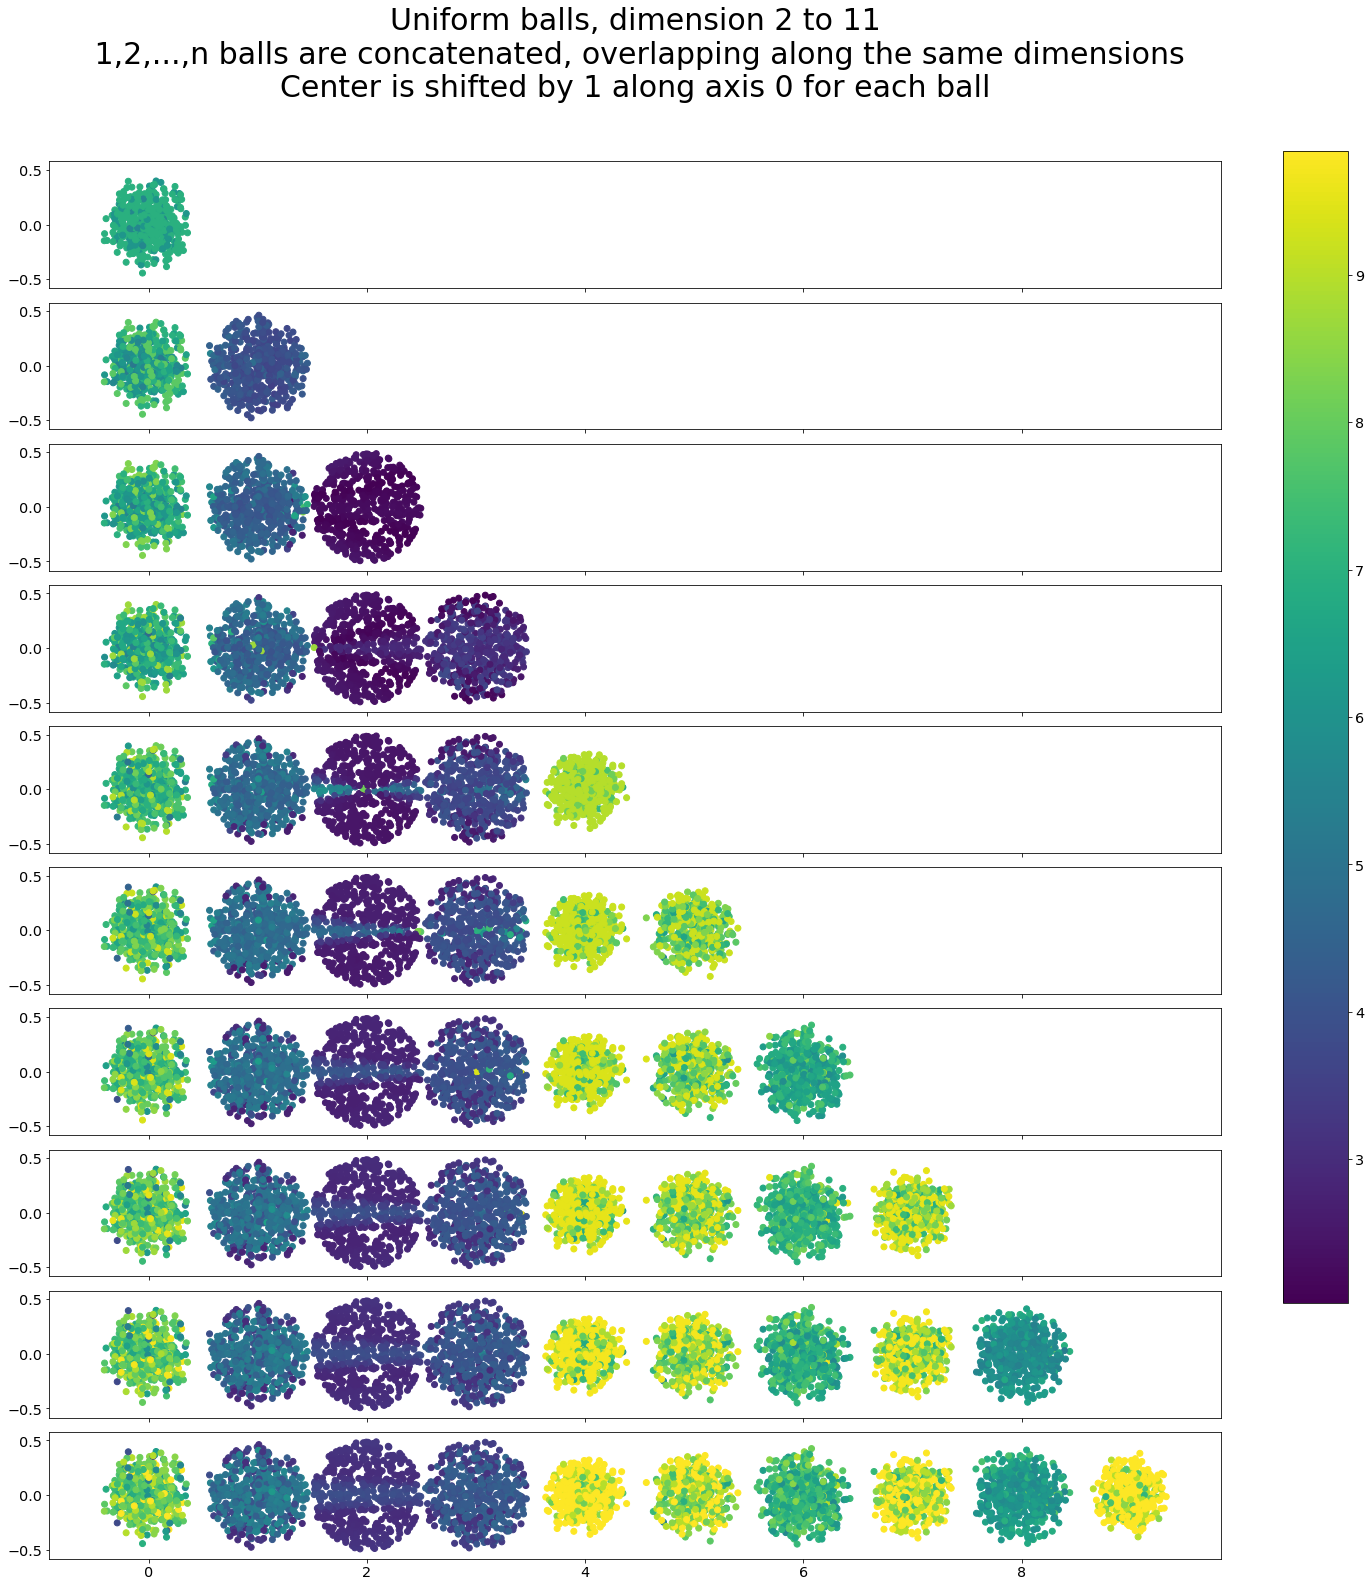

In [30]:
fig,axes = plt.subplots(10,1,figsize=(30,20),sharex=True, sharey=True)
plt.suptitle('Uniform balls, dimension 2 to 11\n 1,2,...,n balls are concatenated, overlapping along the same dimensions\nCenter is shifted by 1 along axis 0 for each ball',fontsize=30,y=1.1)
ax = list(axes.flat)
xmin = np.min(np.concatenate(list_inseparability_id))
xmax = np.max(np.concatenate(list_inseparability_id))

for i in range(ndatasets):
    color_subplot = ax[i].scatter(list_allballs[i][:,0],list_allballs[i][:,1],label=str(i),c=list_inseparability_id[i],vmin=xmin,vmax=xmax)
    ax[i].axis('scaled')

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=xmin,vmax=xmax)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cbaxes = fig.add_axes([.8, .2, .03, .8]) 
fig.colorbar(sm,ax=axes.ravel().tolist(),cax=cbaxes)
plt.tight_layout()
plt.show()

### Plot, coloring with kNN ID

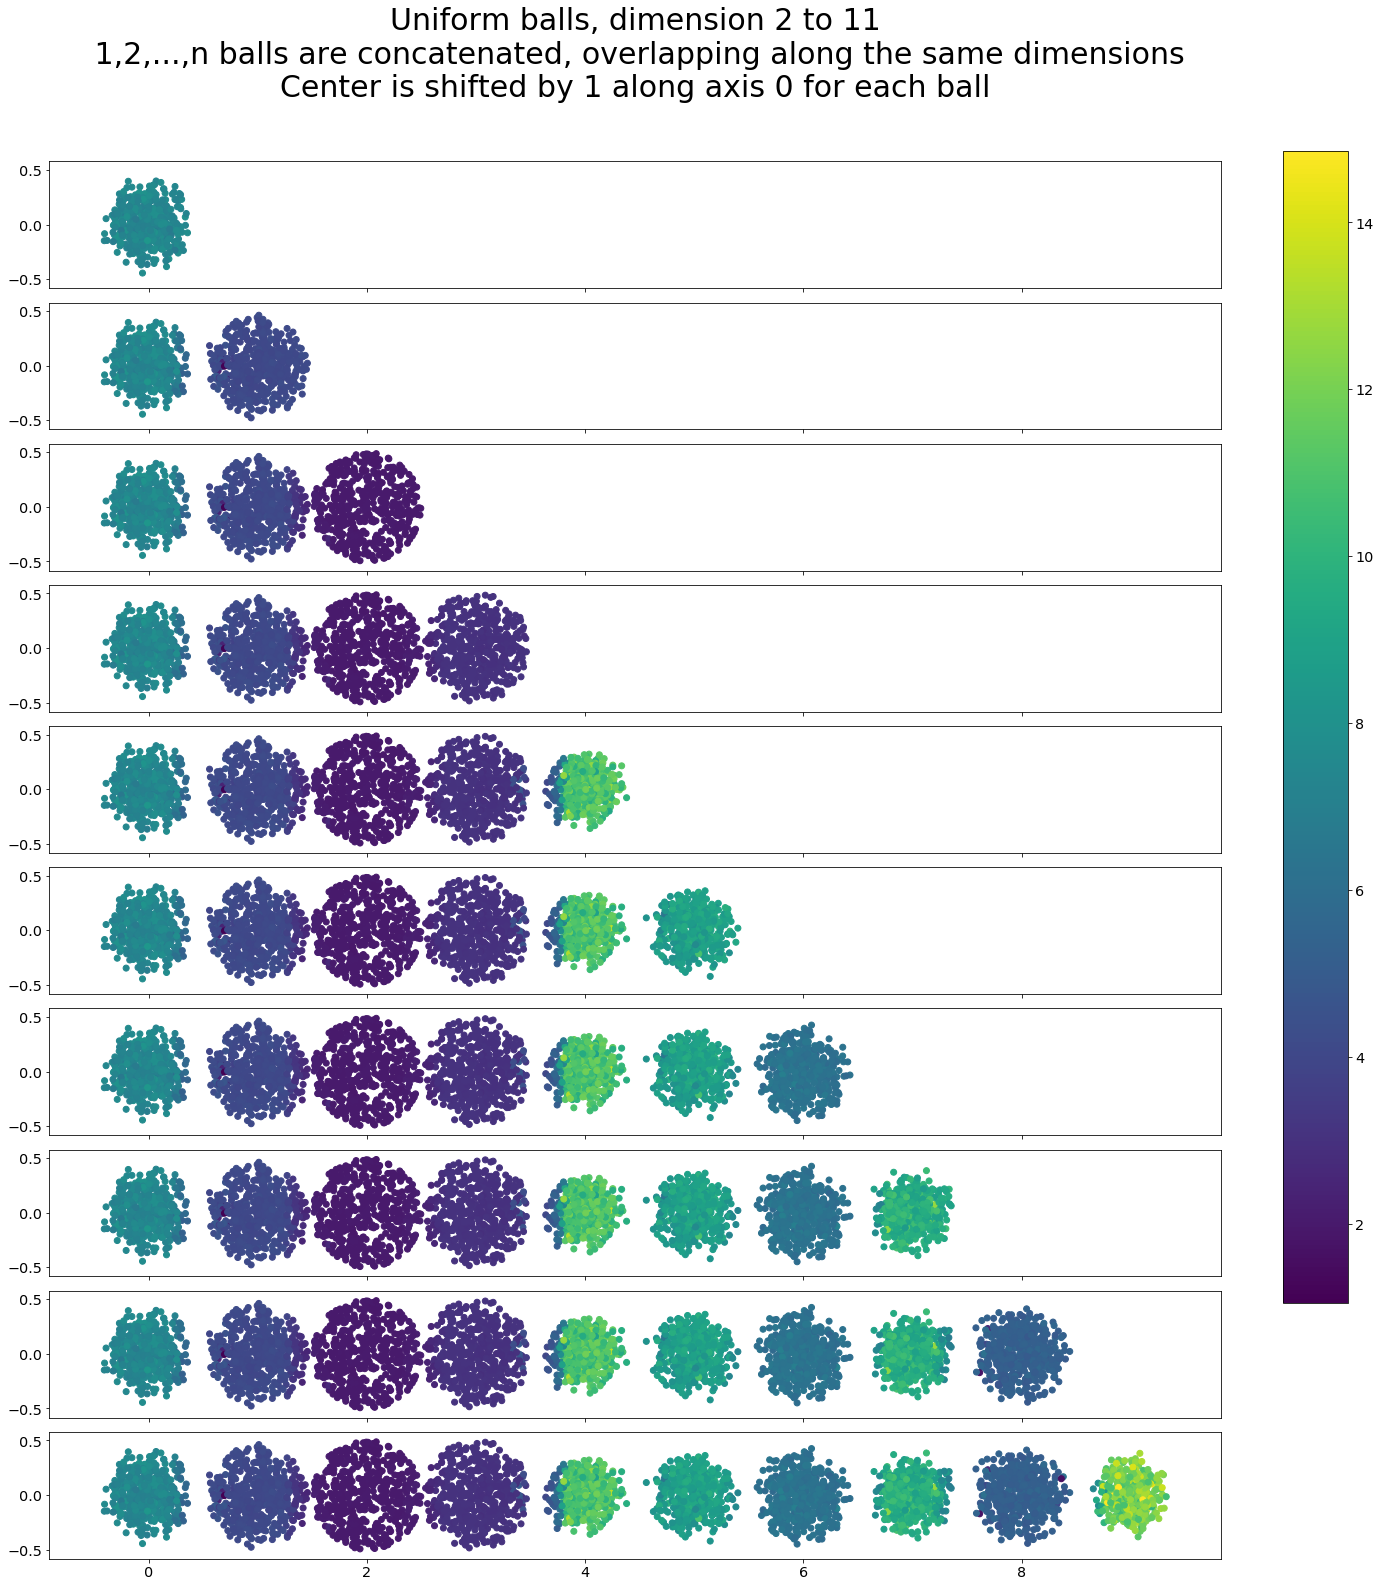

In [31]:
fig,axes = plt.subplots(10,1,figsize=(30,20),sharex=True, sharey=True)
plt.suptitle('Uniform balls, dimension 2 to 11\n 1,2,...,n balls are concatenated, overlapping along the same dimensions\nCenter is shifted by 1 along axis 0 for each ball',fontsize=30,y=1.1)
ax = list(axes.flat)
xmin = np.min(np.concatenate(list_fisher_pw))
xmax = np.max(np.concatenate(list_fisher_pw))

for i in range(ndatasets):
    color_subplot = ax[i].scatter(list_allballs[i][:,0],list_allballs[i][:,1],label=str(i),c=list_fisher_pw[i],vmin=xmin,vmax=xmax)
    ax[i].axis('scaled')

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=xmin,vmax=xmax)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cbaxes = fig.add_axes([.8, .2, .03, .8]) 
fig.colorbar(sm,ax=axes.ravel().tolist(),cax=cbaxes)
plt.tight_layout()
plt.show()

### Plot kNN ID vs ID from inseparability

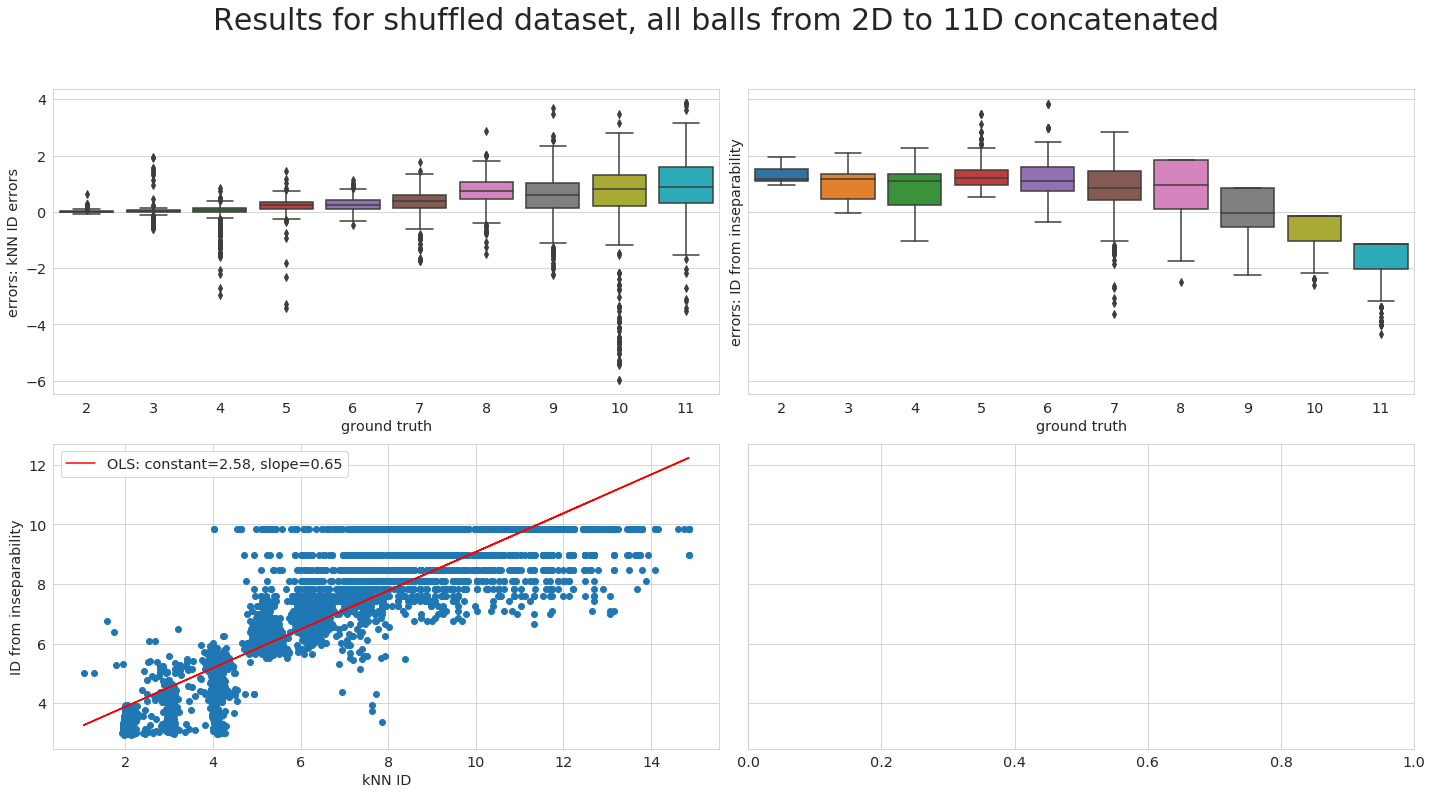

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 2.219e+04
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:08:16   Log-Likelihood:                -7082.3
No. Observations:                5000   AIC:                         1.417e+04
Df Residuals:                    4998   BIC:                         1.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5816      0.033     78.052      0.0

In [32]:
import statsmodels.api as sm
import seaborn as sns
sns.set_style('whitegrid')
f, ax = plt.subplots(2, 2, figsize=(20,10),sharey='row')
plt.suptitle('Results for shuffled dataset, all balls from 2D to 11D concatenated',y=1.1,fontsize=30)

sns.boxplot(np.repeat(shuffled_dims,500),list_fisher_pw[-1]-np.repeat(shuffled_dims,500),ax=ax[0,0])
ax[0,0].set_xlabel('ground truth')
ax[0,0].set_ylabel('errors: kNN ID errors')

sns.boxplot(np.repeat(shuffled_dims,500),list_inseparability_id[-1]-np.repeat(shuffled_dims,500),ax=ax[0,1])
ax[0,1].set_ylabel('errors: ID from inseparability')
ax[0,1].set_xlabel('ground truth')

results = sm.OLS(list_inseparability_id[-1],sm.add_constant(list_fisher_pw[-1])).fit()
xreg = np.array([list_fisher_pw[-1].min(),list_fisher_pw[-1].max()])
ax[1,0].set_title('')
ax[1,0].scatter(list_fisher_pw[-1],list_inseparability_id[-1])
ax[1,0].plot(list_fisher_pw[-1],results.fittedvalues,c='r',label=f'OLS: constant={results.params[0]:.2f}, slope={results.params[1]:.2f}')
ax[1,0].set_xlabel('kNN ID')
ax[1,0].set_ylabel('ID from inseparability')
ax[1,0].legend()

#ax[1,1].scatter(list_inseparability[-1],list_inseparability_id[-1])
#ax[1,1].set_xlabel('inseparability probability')
#ax[1,1].set_ylabel('ID from inseparability')
plt.tight_layout()
plt.show()
print(results.summary())